In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
import math
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
cling::DynamicLibraryManager::loadLibrary(): libGL.so.1: cannot open shared object file: No such file or directory
Error in <AutoloadLibraryMU>: Failed to load library /groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/libEve.so.6.28.00cling JIT session error: Failed to materialize symbols: { (main, { _ZeqRK7TStringRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE }) }


Welcome to JupyROOT 6.28/00


In [2]:
import os

unique_dir = "SDVSecVtx_ParTScore"

# ------------------------------------------------
sig_tag  = 'stop_M600_585_ct20_2018'




histname = "MET_pt_corr_vs_Max_ML_score"
tdir     = "all_evt"




bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/sig"



sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_dir  = getattr(sig_file, tdir)
sig_hist = getattr(sig_dir, histname).Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_dir  = getattr(bkg_file, tdir)
bkg_hist = getattr(bkg_dir, histname).Clone()

In [3]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [4]:
xax = sig_hist.GetXaxis()
yax = sig_hist.GetYaxis()

x_min = xax.GetBinLowEdge(1)
x_max = xax.GetBinUpEdge(xax.GetLast())

y_min = yax.GetBinLowEdge(1)
y_max = yax.GetBinUpEdge(yax.GetLast())

print(x_min, x_max, x_binwidth)
print(y_min, y_max, y_binwidth)

0.0 1000.0 50.0
0.0 1.0 0.002


In [5]:
MET_boundaryList     = np.arange(200   + x_binwidth, x_max, x_binwidth)
MLScore_boundaryList = np.arange(y_min + y_binwidth, y_max, y_binwidth)

In [6]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

print(MET_boundaryList)
print(MLScore_boundaryList)

MLScore_min = bkg_hist.GetYaxis().FindBin(0.50)

[250. 300. 350. 400. 450. 500. 550. 600. 650. 700. 750. 800. 850. 900.
 950.]
[0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024
 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046 0.048
 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07  0.072
 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288
 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304

In [7]:
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def makeTables(
        xedges: np.ndarray,
        yedges: np.ndarray,
        bkg_hist: ROOT.TH2,
        sig_hist: ROOT.TH2,
        x_loCut: float = 0.0,
        y_loCut: float = 0.0,
        sigScale: float = 1.0,
        bkgScale: float = 1.0,
):
    x_step = xedges[1] - xedges[0]
    y_step = yedges[1] - yedges[0]
    empty_df = pd.DataFrame(index=np.arange(xedges[0], xedges[-1]+x_step, x_step),
                            columns=np.arange(yedges[0], yedges[-1]+y_step, y_step),
                            dtype= float)

    # Create empty tables
    tableNames = ['sig_NA', 'sig_NB', 'sig_NC', 'sig_ND',
                  'bkg_NA', 'bkg_NB', 'bkg_NC', 'bkg_ND',
                  'sig_NA_unc', 'sig_NB_unc', 'sig_NC_unc', 'sig_ND_unc',
                  'bkg_NA_unc', 'bkg_NB_unc', 'bkg_NC_unc', 'bkg_ND_unc',
                  'Z_NA', 'Z_NB', 'Z_NC', 'Z_ND',
                  'noncl', 'noncl_unc',
                ]
    tables = dict()
    for name in tableNames:
        tables[name] = empty_df.copy()
     
    for x_boundary in xedges:
        for y_boundary in yedges:
            x_lo    = bkg_hist.GetXaxis().FindBin(x_loCut)
            x_up    = bkg_hist.GetNbinsX()+1
            x_bound = bkg_hist.GetXaxis().FindBin(x_boundary)

            y_lo    = bkg_hist.GetYaxis().FindBin(y_loCut)
            y_up    = bkg_hist.GetNbinsY()+1
            y_bound = bkg_hist.GetYaxis().FindBin(y_boundary)


            # ------------ Backgrounds --------------
            c_err = c_double(0.0)
            NA = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NB = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NC = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale
            ND = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale

            num   = NB * NC
            denom = NA * ND
            noncl = np.abs(1- num/denom) if ND.n > 0 else ufloat(0.0, 0.0)

            eps = 5e-1

            tables['bkg_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['bkg_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['bkg_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['bkg_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['bkg_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['bkg_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['bkg_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['bkg_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            tables['noncl'].loc[x_boundary, y_boundary]     = noncl.n
            tables['noncl_unc'].loc[x_boundary, y_boundary] = noncl.s
            

            # ------------ Signals --------------
            c_err = c_double(0.0)
            NA = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * sigScale
            NB = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * sigScale
            NC = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * sigScale
            ND = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * sigScale

            eps = 5e-1

            tables['sig_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['sig_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['sig_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['sig_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['sig_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['sig_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['sig_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['sig_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)


            # ------------ Closure --------------
            


    return tables

In [10]:
tables = makeTables(
    MET_boundaryList,
    MLScore_boundaryList[::4],
    bkg_hist,
    sig_hist,
    x_loCut = x_min,
    y_loCut = y_min,
    sigScale = 1.0,
    bkgScale = 1.0,
)

/tmp/ipykernel_29873/1831603421.py:53: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  noncl = np.abs(1- num/denom) if ND.n > 0 else ufloat(0.0, 0.0)


In [14]:
noncl = tables['noncl']
# noncl_plus1s = tables['noncl'] + tables['noncl_unc']

In [15]:
noncl

,0.002,0.010,0.018,0.026,0.034,0.042,0.050,0.058,0.066,0.074,...,0.922,0.930,0.938,0.946,0.954,0.962,0.970,0.978,0.986,0.994
250.0,0.080589,0.033732,0.034844,0.041289,0.044094,0.044295,0.046180,0.044761,0.042895,0.040893,...,0.005247,0.014113,0.005504,0.017010,0.044954,0.060053,0.012345,0.013324,0.035317,0.026764
300.0,0.227894,0.052491,0.050114,0.051375,0.054069,0.057279,0.059216,0.058627,0.057051,0.055383,...,0.024681,0.021010,0.038713,0.034337,0.011674,0.013923,0.068950,0.062319,0.052145,0.083636
350.0,0.229206,0.065990,0.067101,0.068436,0.070409,0.069464,0.071774,0.070764,0.067711,0.064869,...,0.027884,0.027490,0.046906,0.034333,0.003479,0.003590,0.035850,0.006338,0.004646,0.093170
400.0,0.252410,0.085362,0.086028,0.084591,0.087236,0.085513,0.084223,0.082526,0.080392,0.077746,...,0.010048,0.008040,0.005376,0.029213,0.046157,0.053590,0.010224,0.006663,0.010040,0.062161
450.0,0.225282,0.095622,0.095484,0.093530,0.097766,0.097355,0.096425,0.094269,0.091286,0.088593,...,0.000192,0.005504,0.022909,0.010338,0.034421,0.057812,0.006501,0.026204,0.002423,0.038082
500.0,0.218426,0.105604,0.100043,0.099486,0.102825,0.102513,0.101656,0.100979,0.098810,0.095761,...,0.041050,0.032219,0.043447,0.036430,0.022792,0.010712,0.042850,0.000074,0.024644,0.025407
550.0,0.224026,0.114767,0.106330,0.101246,0.103079,0.105267,0.104621,0.105523,0.103822,0.101286,...,0.114924,0.101837,0.108750,0.103738,0.090278,0.098184,0.140579,0.103919,0.144299,0.104073
600.0,0.232759,0.116088,0.108756,0.106604,0.106694,0.108721,0.105957,0.106193,0.104269,0.102040,...,0.129748,0.115959,0.126369,0.098095,0.081215,0.064386,0.119736,0.065454,0.170271,0.008840
650.0,0.263376,0.107220,0.107480,0.110330,0.106738,0.108924,0.107454,0.108588,0.109053,0.108906,...,0.084845,0.082619,0.083489,0.087280,0.070379,0.034025,0.119811,0.018961,0.063057,0.045401
700.0,0.275346,0.116272,0.112872,0.114839,0.107867,0.110458,0.107538,0.108836,0.108587,0.109487,...,0.115786,0.124090,0.108727,0.124530,0.141383,0.105721,0.165758,0.131699,0.212934,0.112478


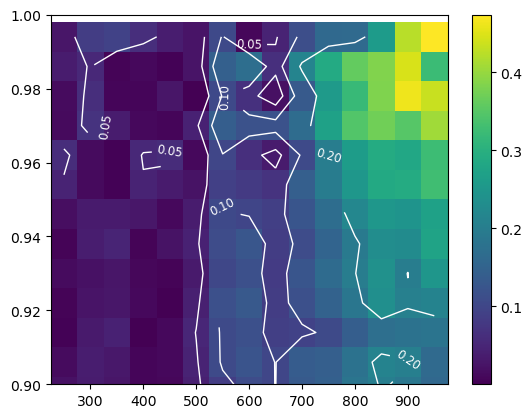

In [12]:
import matplotlib.pyplot as plt
noncl = tables['noncl']

pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

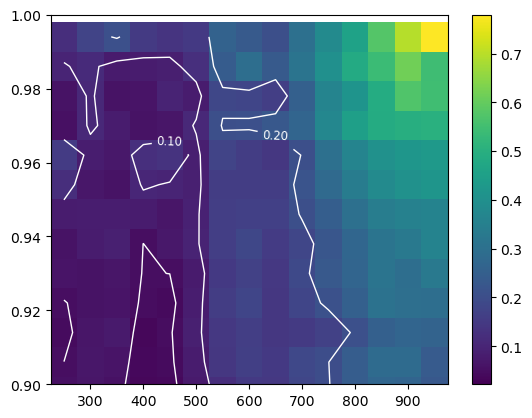

In [13]:
import matplotlib.pyplot as plt
noncl = tables['noncl'] + tables['noncl_unc']
pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

In [137]:
noncl.columns

Index([               0.002,                 0.01, 0.018000000000000002,
       0.026000000000000002,                0.034,                0.042,
                       0.05,                0.058,                0.066,
        0.07400000000000001,
       ...
                      0.922,                 0.93,   0.9380000000000001,
         0.9460000000000001,   0.9540000000000001,                0.962,
                       0.97,                0.978,                0.986,
                      0.994],
      dtype='float64', length=125)

In [54]:
# store.keys()
# store = pd.HDFStore(os.path.join(significances_dir, 'dataframes.h5'), 'r')
# store.close()

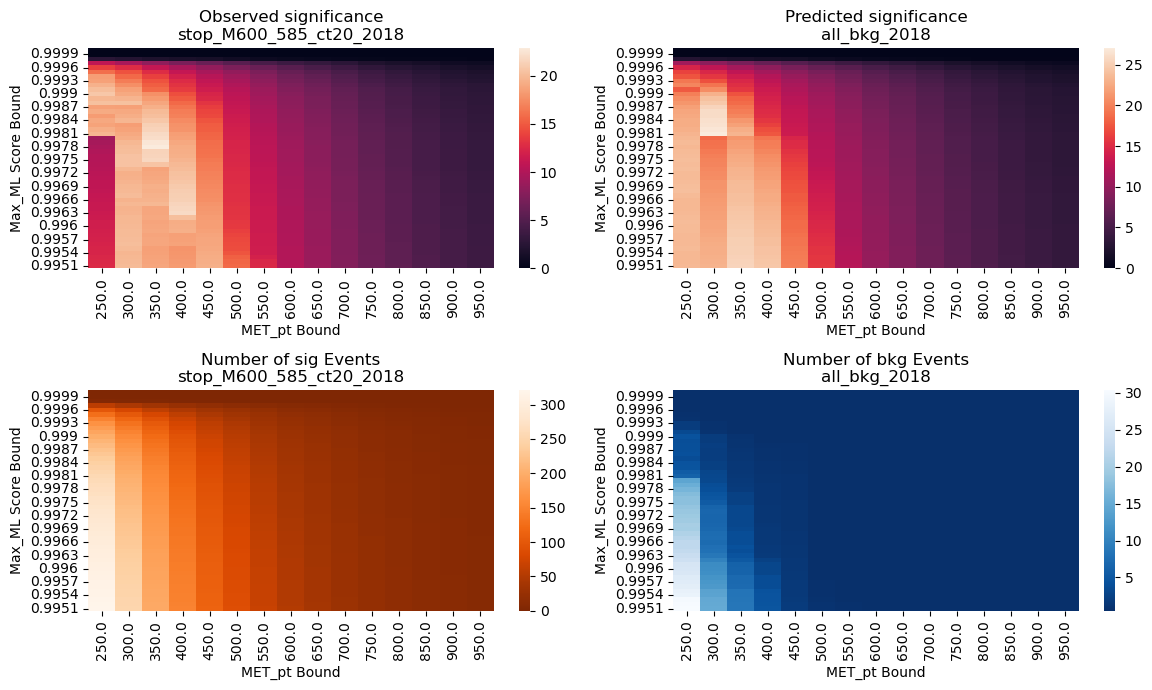

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
tag=sig_tag

ylabel = 'Max_ML Score Bound'
xlabel = 'MET_pt Bound'

plot_lowerBound = 0.995 # y_min

# Observed significance plot
sns.heatmap(store[tag + '_Z_NA'][plot_lowerBound:], ax=axs[0,0])
axs[0,0].set(xlabel=xlabel, ylabel=ylabel, title='Observed significance\n' + tag)
axs[0,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,0].get_yticklabels())])
axs[0,0].invert_yaxis()

# Predicted significance plot
sns.heatmap(store[tag + '_Z_NA_pred'][plot_lowerBound:], ax=axs[0,1])
axs[0,1].set(xlabel=xlabel, ylabel=ylabel, title='Predicted significance\n' + 'all_bkg_2018')
axs[0,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,1].get_yticklabels())])
axs[0,1].invert_yaxis()

# Signal plot
sns.heatmap(store[tag + '_sig_NA'][plot_lowerBound:], cmap='Oranges_r', ax=axs[1,0])
axs[1,0].set(xlabel=xlabel, ylabel=ylabel, title='Number of sig Events\n' + tag)
axs[1,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,0].get_yticklabels())])
axs[1,0].invert_yaxis()

# Background plot
sns.heatmap(store[tag + '_bkg_NA'][plot_lowerBound:], cmap='Blues_r', ax=axs[1,1])
axs[1,1].set(xlabel=xlabel, ylabel=ylabel, title='Number of bkg Events\n' + 'all_bkg_2018')
axs[1,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,1].get_yticklabels())])
axs[1,1].invert_yaxis()

fig.tight_layout()
fig.show()


In [ ]:
print(round(store[sig_tag + "_bkg_NB"].index[-1], 6))
print(round(store[sig_tag + "_bkg_NB"].columns[3], 0))

1.0
400.0


In [ ]:
store[sig_tag + '_Z_NA'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,2.251967,2.248273,2.358847,2.584172,2.093402
0.9992,2.396072,2.377766,2.616129,2.468251,1.996291
0.9993,2.498369,2.496633,2.885505,2.827767,2.352038
0.9994,2.563554,2.564731,2.658907,2.631246,2.178834
0.9995,2.428701,2.923958,2.873030,2.385870,1.973153
0.9996,2.009180,2.455386,2.447137,2.025664,1.669822
0.9997,1.796135,2.066270,1.690499,1.368592,1.100158
0.9998,0.343160,0.262500,0.217354,0.160269,0.141193
0.9999,0.000000,0.000000,0.000000,0.000000,0.000000
1.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
store[sig_tag + '_Z_NA'].iloc[-2,3]

0.0

In [ ]:
# print(f'NA: {store[sig_tag + "_bkg_NA"].iloc[-8,3]} +/- {store[sig_tag + "_bkg_NA_unc"].iloc[-8,3]}')
print(f'NB: {store[sig_tag + "_bkg_NB"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_NB_unc"].iloc[-2,3]}')
print(f'NC: {store[sig_tag + "_bkg_NC"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_NC_unc"].iloc[-2,3]}')
print(f'ND: {store[sig_tag + "_bkg_ND"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_ND_unc"].iloc[-2,3]}')


SPRB: 75.7265844695817 +/- 11.04753814938583
SPRC: 5645.954460377956 +/- 59.421774212011265
SPRD: 122403.78773063312 +/- 780.8326371959705


In [132]:
f_B = ufloat(64.95118090785805, 10.24168017233881) / ufloat(129.74137883499245, 18.46953400253708)
f_C = ufloat(4972.575722054323, 63.20730017273657) / ufloat(9642.685986809784, 100.02463163394061)
f_D = ufloat(95650.71685582052, 838.9132564909049) / ufloat(208527.3141139648, 1311.1127886045672)

print("f_B:", f_B)
print("f_C:", f_C)
print("f_D:", f_D)

f_B: 0.50+/-0.11
f_C: 0.516+/-0.008
f_D: 0.459+/-0.005


In [135]:
(f_C/f_D) * f_B * ufloat(129.74137883499245, 18.46953400253708)

73.02055892221767+/-18.728064863359897

In [ ]:
store[tag + '_sig_NB'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,3.613198,7.012396,9.729498,11.870316,13.441857
0.9992,3.430240,6.647844,9.205820,11.239286,12.717320
0.9993,3.153858,6.106644,8.487057,10.344897,11.692171
0.9994,2.807500,5.466843,7.638892,9.292307,10.506040
0.9995,2.460162,4.685567,6.579326,7.992253,9.021895
0.9996,1.860485,3.607206,5.074650,6.163022,6.950905
0.9997,1.088727,2.047721,2.895871,3.543033,4.010537
0.9998,0.113476,0.199834,0.246228,0.306457,0.324906
0.9999,0.000000,0.000000,0.000000,0.000000,0.000000
1.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
store[tag + '_bkg_NA'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,15.328985,10.383760,4.543043,2.194217,1.638586
0.9992,11.188561,7.580735,2.873501,1.691053,1.544584
0.9993,8.798071,5.377026,1.658631,0.500000,0.500000
0.9994,5.368376,3.704655,1.338651,0.500000,0.500000
0.9995,2.607061,1.562292,0.500000,0.500000,0.500000
0.9996,1.198395,1.055269,0.500000,0.500000,0.500000
0.9997,0.500000,0.500000,0.500000,0.500000,0.500000
0.9998,0.500000,0.500000,0.500000,0.500000,0.500000
0.9999,0.500000,0.500000,0.500000,0.500000,0.500000
1.0000,0.500000,0.500000,0.500000,0.500000,0.500000


In [ ]:
store[tag + '_sig_NA'].loc[0.998:]

In [ ]:
store[tag + '_bkg_NA'].loc[0.998:]

In [ ]:
store[tag + '_signifTable'].loc[0.995:, 200:500]

In [ ]:
print(store[tag + '_signifTable'].loc[0.999:, 200:500].to_markdown())

In [ ]:
iML  = -12
iMET = +4
sysUnc = 0.20

print(f"Regions for {sig_tag} (with {sysUnc*100:.0f}% bkg syst. unc.)")
print("Integrated luminosity = 100 fb-1")
print("Cross-section is scaled down to 6.83 fb")
print()
print(f"ML_cut:  {store[sig_tag + '_sig_NA_Table'].index[iML]:.5f}")
print(f"MET_cut: {store[sig_tag + '_sig_NA_Table'].columns[iMET]:.0f}")
print()

print("Signal")
print("."*40)
print("A: ", round(store[sig_tag + '_sig_NA_Table'].iloc[iML,iMET], 2))
print("B: ", round(store[sig_tag + '_sig_NB_Table'].iloc[iML,iMET], 2))
print("C: ", round(store[sig_tag + '_sig_NC_Table'].iloc[iML,iMET], 2))
print("D: ", round(store[sig_tag + '_sig_ND_Table'].iloc[iML,iMET], 2))
print()
print("Background")
print("."*40)
print("A: ", round(store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET], 2))
print("B: ", round(store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET], 2))
print("C: ", round(store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET], 2))
print("D: ", round(store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET], 2))
print()
print("ROOT RooStats AsimovSignificance")
print("."*40)
print("A: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NA_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET] * sysUnc), 2))

print("B: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NB_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET] * sysUnc), 2))

print("C: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NC_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET] * sysUnc), 2))

print("D: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_ND_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET] * sysUnc), 2))



In [ ]:
store[tag + '_sigTable'].loc[0.9970:, 200:500]

In [ ]:
store[tag + '_bkgTable'].loc[0.9970:, 200:500]

In [ ]:
sig(146.269714, 0, 0)

In [ ]:
store[tag + '_bkgpredTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_sigTable'].loc[0.998:0.999]

In [ ]:
store[tag + '_signifTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_signifpredTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_signifTable'].loc[0.998:0.999]

In [ ]:
tmp_df = store[tag + '_signifTable'].to_numpy()
tmp_df[np.isnan(tmp_df)] = 0.
np.where(tmp_df == tmp_df.max())
store[tag + '_signifTable'].iloc[50:150:10,5:6]

In [ ]:
store[tag + '_signifTable'].index[116]

In [ ]:
df = store[tag + '_signifpredTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

In [ ]:
from matplotlib.colors import LogNorm, Normalize

In [ ]:
s = sns.heatmap(store[tag + '_sigTable'], norm=LogNorm(), cmap='Oranges_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of sig Events\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
s = sns.heatmap(store[tag + '_bkgTable'], norm=LogNorm(), cmap='Blues_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of bkg Events\n'+"all_bkg");
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
# store[tag + '_signifTable']

In [ ]:
df = store[tag + '_signifTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

In [ ]:
df[~df.isna()]

In [ ]:
store[tag + '_sigTable'][0.992:]

In [ ]:
store[tag + '_bkgTable'][0.992:]

In [ ]:
store[tag + '_bkgpredTable'][0.992:]

In [ ]:
store[tag + '_bkgpredTable'][0.992:] / store[tag + '_bkgTable'][0.992:]

In [ ]:
store[tag + '_bkgpredUncTable'][0.992:]

In [ ]:
store[tag + '_bkgUncTable'][0.992:]

In [ ]:
store[tag + '_bkgUncTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgpredUncTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgpredTable'].loc[0.998:,1000]

In [ ]:
(store[tag + '_bkgpredTable'].loc[0.998:,1000]/ store[tag + '_bkgpredUncTable'].loc[0.998:,1000])**2

In [ ]:
(0.00782 / 0.002401)**2

In [ ]:
(0.056571 / 0.056571)**2

In [ ]:
ufloat(0.00782, 0.002401) / ufloat(0.056571, 0.056571)

In [ ]:
import ROOT

# --- 1. create one‑bin histograms with your Poisson counts ------------------
h_num = ROOT.TH1D("num","",1,0,1)   # numerator: n1
h_den = ROOT.TH1D("den","",1,0,1)   # denominator: n2
h_num.SetBinContent(1, 10)          # e.g. n1 = 10
h_den.SetBinContent(1, 1)          # e.g. n2 = 73   (change to your numbers)

# --- 2. build the ratio of Poisson means with 68.3 % (1 σ) Clopper‑Pearson --
g = ROOT.TGraphAsymmErrors()
g.Divide(h_num, h_den, "pois cp")   # add "v" for verbose output if you like

# --- 3. access the central value and asymmetric errors ----------------------
ratio      = g.GetY()[0]            # τ̂  = n1 / n2
err_low    = g.GetErrorYlow(0)      # downward error
err_high   = g.GetErrorYhigh(0)     # upward   error
print(f"τ = {ratio:.6f}  +{err_high:.6f}/-{err_low:.6f}")

# optional: draw the graph (as a single point)
# c = ROOT.TCanvas()
# g.SetMarkerStyle(20)
# g.Draw("AP")
# c.Update()


In [ ]:
g.Divide(h_num, h_den, "pois fc")                   # Feldman‑Cousins 68 % CL
g.Divide(h_num, h_den, "pois b(0.5,0.5) shortest")  # Bayesian Jeffreys prior

In [ ]:
from uncertainties import ufloat

def ratio_gauss(muA, sigA, muB, sigB):
    """
    Return R = A/B with its propagated 1‑sigma error,
    assuming A and B are independent Gaussians.
    """
    a = ufloat(muA, sigA)
    b = ufloat(muB, sigB)
    return a / b

# example -------------------------------------------------------------
ra = ratio_gauss(0.00782,   0.002401,
                 0.056571,  0.056571)
print(ra)        # ==> 0.138233±0.144602

In [ ]:
from scipy import stats
import numpy as np

my_dict = {}
my_val = 0.7

mu1s_68 = []
mu2s_68 = []

mu1s_95 = []
mu2s_95 = []

trial1s = np.random.uniform(0, 300, 10000)
trial2s = np.random.uniform(0, 300, 10000)

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=1000)
    rvs2 = stats.poisson.rvs(mu2, size=1000)
    rvs_ratio = rvs1 / rvs2
    ci68 = np.percentile(rvs_ratio, [16, 84])
    ci95 = np.percentile(rvs_ratio, [2.5, 97.5])
    # if np.isnan(ci68[0]) or np.isnan(ci68[1]):
    #     continue
    if ci68[0] <= my_val <= ci68[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_68.append(mu1)
        mu2s_68.append(mu2)
    if ci95[0] <= my_val <= ci95[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_95.append(mu1)
        mu2s_95.append(mu2)
        
        # my_dict[f'{mu1:.2f}_{mu2:.2f}'] = x

In [ ]:
rvs1 = stats.poisson.rvs(200, size=1000)
rvs2 = stats.poisson.rvs(300, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 84])
x

In [ ]:
plt.plot(mu1s_68, mu2s_68, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [ ]:
plt.plot(mu1s_95, mu2s_95, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [ ]:
l = [0, 2]
my_val = np.nan

if l[0] > my_val or l[-1] < my_val :
    print("my_val is outside the range of l")


In [ ]:
rvs1 = stats.poisson.rvs(20, size=1000)
rvs2 = stats.poisson.rvs(10, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 50, 84])
x

In [ ]:
store[tag + '_closureUncTable'][0.992:]

In [ ]:
store[tag + '_signifTable'][0.992:]

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'][0.992:], annot=True)
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();
plt.

In [ ]:
# d.to_csv(sep = "|")
tableName = tag + '_bkgTable'
print(f"Printing {tableName} \n")
d = store[tableName]
s = d.to_markdown()
s = "| ParTScore/MET_pt" + s[6:]
print(s)

In [ ]:
for key in bkg_histDict.keys():
    print(key)

In [ ]:
c = ROOT.TCanvas("c1","myCanvas1",600,600)
h = bkg_histDict['zjetstonunuht2500_2018']
h.Draw("COLZ")
h.GetXaxis().SetRange(-1, 1000)
h.GetYaxis().SetRange(-1, 1000)
c.Draw()

In [ ]:
sig(15.903, 4.079, 0.4513)

In [ ]:
sig(5, 4.079, 0.4513)

In [ ]:
5 / 15.903

In [ ]:
store[tag + '_sigTable']

In [ ]:
tag = 'stop_1000_980_2'

s = sns.heatmap(store[tag + '_bkgTable'], cmap="Blues_r")
s.set(xlabel='MET_pt', ylabel='LxySig', title='STOP Events\n'+tag);
s.invert_yaxis();

In [ ]:
# d.to_csv(sep = "|")
tag = 'stop_1000_980_2'
d = store[tag + '_bkgTable']
s = d.to_markdown()
s = "| LxySig/MET_pt " + s[6:]

In [ ]:
print(f"{s}")

In [ ]:
# hist.GetYaxis().GetBinUpEdge(hist.GetYaxis().GetNbins())

In [ ]:
store['stop_1000_988_200_sigTable']

In [ ]:
store['stop_1000_988_200_bkgTable']

In [ ]:
store['stop_1000_988_200_signifTable']

In [ ]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) - 
                    (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))

In [ ]:
sig(0.2, 0.5, 1e-154)

In [ ]:
0.2 / np.sqrt(0.5)